In [1]:
'''
Python 3 code for DECDG data analysis exercise.
The following code are written for the purpose of demonstrating
data analysis process.

The one-pager report can be found at:
https://docs.google.com/document/d/1Jyn5Ksovxl0VoCekrE-12keRJ8C1MehdIDueePyflLM/edit?usp=sharing
'''
# Step 0. Setup
# 0.1 Imports: the following modules are required to reproduce
#     execution result step by step.
import requests
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# 0.2 plotting configurations
plt.figure(figsize=(20,10))
sns.set(font_scale=1.1)
sns.set_context("poster")
sns.set_style("white")
sns.set_palette(sns.color_palette("Greys_d"))

In [2]:
# Step 1. Retrieve life expectancy data from World Bank API
# Following the WDI API documentation, I constructed the API query as below to pull data as a JSON file.
URL = 'http://api.worldbank.org/countries/all/indicators/SP.DYN.LE00.IN?date=1960:2017&per_page=15048&format=json'

In [3]:
r = requests.get(URL)

In [4]:
# Step 2. Data Wrangling (structuring semi-structured JSON file into tabular data, then impute missing values)
# 2.1 Structure data
#     To do this, I will flatten out nested JSON format as tabular DataFrame.
df = pd.io.json.json_normalize(r.json()[1])

In [5]:
# 2.2 Selecting country id, country name, year, and life expectancy value columns.
df = df[['country.value','date','value']]

# 2.3 Normalize column names -- Pandas likes snake case.
df.columns = ['country', 'year', 'life_expectancy']

In [6]:
# 2.4 Identify data quality problem:
# 2.4.1 Problem 1: Missing values in "life_expectancy" column
#       Because the missing data is small and will not bias the
#       analysis outcome, there is no need to treat it.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15048 entries, 0 to 15047
Data columns (total 3 columns):
country            15048 non-null object
year               15048 non-null object
life_expectancy    13498 non-null object
dtypes: object(3)
memory usage: 352.8+ KB


In [7]:
# 2.4.2 Problem 2: incorrect data type in DataFrame.
# For this, I will simply convert "year" and "life_expectancy" string value
# for calculation.
df.life_expectancy = pd.to_numeric(df.life_expectancy)
df.year = df.year.astype('int')

In [8]:
# 2.5 Save cleaned data
df.to_pickle('life_expectancy_data_cleaned.pkl')
df = pd.read_pickle('life_expectancy_data_cleaned.pkl')

Step 3. Conduct exploratory data analysis (no document required).

In [9]:
# Step 4. Choose one aspect or trend of the dat worth highlighting.
#         Life expectancy is known to have closely correlated with
#         income level, which is also a WDI indicator and included
#         in the life expectancy dataset.
#         So, I will take a closer look at this correlation.

In [10]:
# create dummy variables for income levels to run linear regression.
HIC = df[df.country=='High income']
UMC = df[df.country=='Upper middle income']
MIC = df[df.country=='Middle income']
LMC = df[df.country=='Lower middle income']
LIC = df[df.country=='Low income']

df_income = pd.concat([HIC, UMC, MIC, LMC, LIC])
df_income.coutry = df_income.country.astype('category')
binary_cols = pd.get_dummies(df_income.country)
df_income = pd.merge(df_income, binary_cols, left_index=True, right_index=True, how='inner')

In [11]:
# Show top 3 rows.
df_income.head(3)

,country,year,life_expectancy,High income,Low income,Lower middle income,Middle income,Upper middle income
798,High income,2016,NaN,1,0,0,0,0
799,High income,2015,80.779647,1,0,0,0,0
800,High income,2014,80.651833,1,0,0,0,0


In [12]:
df_income.columns = ['country',
                     'year',
                     'life_expectancy',
                     'high_income',
                     'low_income',
                     'lower_middle_income',
                     'middle_income',
                     'upper_middle_income']

In [14]:
# run regression
result = sm.ols(formula="life_expectancy ~ high_income + upper_middle_income + middle_income + lower_middle_income + low_income", data=df_income).fit()

In [15]:
# From a preliminary linear regression, we can see that
# the correlation between life expectancy and income level
# are significant.
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     137.3
Date:                Fri, 07 Jul 2017   Prob (F-statistic):           2.55e-64
Time:                        23:36:40   Log-Likelihood:                -897.33
No. Observations:                 280   AIC:                             1805.
Df Residuals:                     275   BIC:                             1823.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              51.6858      0.300    172.447      0.000      51.096      52.276
high_income            23.1063      0.722     32.011      0.000      21.685      24.527
upper_middle_income    14.3124      0.722     19.828      0.000      12.891      15.733
middle_income          10.3618      0.722     14.355      0.000       8.941      11.783
lower_middle_income     6.1887      0.722      8.574      0.000       4.768       7.610
low_income             -2.2835      0.722     -3.164      0.002      -3.704      -0.862
==============================================================================
Omnibus:                       10.265   Durbin-Watson:                   0.210
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.585
Skew:                          -0.451   Prob(JB):                      0.00503
Kurtosis:                       2.697   Cond. No.                     1.47e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.55e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

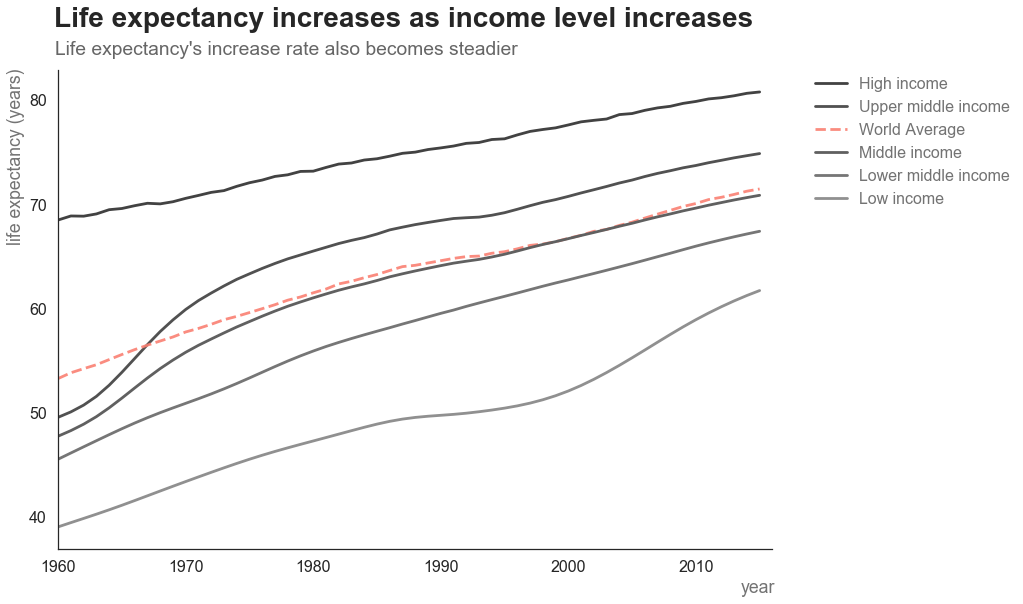

In [18]:
# Step 5. Produce one high quality chart that will convey the main finding of analysis
HIC.life_expectancy.groupby(df.year).mean().plot.line(label='High income')
UMC.life_expectancy.groupby(df.year).mean().plot.line(label='Upper middle income')
df.life_expectancy.groupby(df.year).mean().plot.line(label='World Average',
                                                     color='salmon',
                                                     linestyle='dashed',
                                                     alpha=0.9)
MIC.life_expectancy.groupby(df.year).mean().plot.line(label='Middle income')
LMC.life_expectancy.groupby(df.year).mean().plot.line(label='Lower middle income')
LIC.life_expectancy.groupby(df.year).mean().plot.line(label='Low income')

plt.suptitle("Life expectancy increases as income level increases", fontsize=28, fontweight='semibold')
plt.title("Life expectancy's increase rate also becomes steadier", x=0.32, y=1.02, color='0.4')
plt.xlabel('year', color='0.45', x=0.98)
plt.ylabel('life expectancy (years)', color='0.45', y=0.82)

sns.despine(top=True, right=True)#, left=True, bottom=True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
for text in legend.get_texts():
    plt.setp(text, color='0.45')

In [50]:
# Step 6: Summarize finding into one short paragraph (see one-page report please).

C'est la fin.